In [1]:
import numpy as np 
import pandas as pd
import joblib
import tensorflow as tf
from matplotlib import pyplot as plt

from transformer import LowercaseTransformer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

import warnings
warnings.filterwarnings("ignore")

2024-02-16 18:30:12.288558: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-16 18:30:12.290574: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-16 18:30:12.314935: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-16 18:30:12.314964: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-16 18:30:12.315810: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

# Data Preprocessing

In [2]:
df = pd.read_csv('Luxury watch.csv')
df

,Brand,Model,Case Material,Strap Material,Movement Type,Water Resistance,Case Diameter (mm),Case Thickness (mm),Band Width (mm),Dial Color,Crystal Material,Complications,Power Reserve,Price (USD)
0,Rolex,Submariner,Stainless Steel,Stainless Steel,Automatic,300 meters,40.0,13.00,20.0,Black,Sapphire,Date,48 hours,"9,500"
1,Omega,Seamaster,Titanium,Rubber,Automatic,600 meters,43.5,14.47,21.0,Blue,Sapphire,Date,60 hours,"5,800"
2,Tag Heuer,Carrera,Stainless Steel,Leather,Automatic,100 meters,41.0,13.00,20.0,White,Sapphire,Chronograph,42 hours,"4,200"
3,Breitling,Navitimer,Stainless Steel,Stainless Steel,Automatic,30 meters,43.0,14.25,22.0,Black,Sapphire,Chronograph,70 hours,"7,900"
4,Cartier,Tank Solo,Stainless Steel,Leather,Quartz,30 meters,31.0,6.05,20.0,Silver,Sapphire,NaN,NaN,"2,800"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,Breguet,Classique,18k Rose Gold,Leather,Automatic,30 meters,38.5,8.25,20.0,White,Sapphire,Date,38 hours,"21,500"
503,Blancpain,Fifty Fathoms,Stainless Steel,Fabric,Automatic,300 meters,45.0,15.50,23.0,Black,Sapphire,Date,120 hours,"13,500"
504,Longines,Master Collection,Stainless Steel,Leather,Automatic,30 meters,38.5,9.70,20.0,Blue,Sapphire,Date,64 hours,"1,800"
505,Vacheron Constantin,Overseas,Stainless Steel,Stainless Steel,Automatic,150 meters,41.5,11.00,22.0,Blue,Sapphire,Date,40 hours,"19,000"


### Make the target column, water resistance and power reserve to be of type float instead of object

In [3]:
df['Price (USD)'] = df['Price (USD)'].apply(lambda x: float(str(x).replace(',','')))

df['Water Resistance'] = df['Water Resistance'].apply(lambda x: float(str(x).replace('meters', '')))

# Function to convert days to hours
def convert_days_to_hours(value):
    if pd.notna(value):  # Check if the value is not NaN
        if 'days' in value:
            days = int(value.split()[0])
            return days * 24
        elif 'hours' in value:
            return int(value.split()[0])
        else: return np.nan
    else:
        return value  # Return NaN if the input is NaN
# Apply the function to the 'Power Reserve' column
df['Power Reserve'] = df['Power Reserve'].apply(convert_days_to_hours)
df['Power Reserve'] = df['Power Reserve'].apply(lambda x: float(str(x).replace('hours', '')))

### Remove rows that contain nan values

In [4]:
# df.dropna(inplace=True)
df.dropna(subset = ['Price (USD)'], inplace=True)

### Remove duplicated rows

In [5]:
df = df.drop_duplicates()

### Remove outliers

In [6]:
df = df.drop(df[df["Power Reserve"] > 1000].index)

In [7]:
df = df.drop(df[df["Water Resistance"] > 1250].index)

### Create column transformer

In [8]:
targetcol = 'Price (USD)'
X = df.loc[:,~df.columns.isin([targetcol])]
y = df.loc[:,df.columns.isin([targetcol])]
catcols = list(X.select_dtypes(include=['object']).columns)
numcols = list(X.select_dtypes(include=['float64','int']).columns)

In [9]:
numcols

['Water Resistance',
 'Case Diameter (mm)',
 'Case Thickness (mm)',
 'Band Width (mm)',
 'Power Reserve']

In [10]:
catcols

['Brand',
 'Model',
 'Case Material',
 'Strap Material',
 'Movement Type',
 'Dial Color',
 'Crystal Material',
 'Complications']

In [11]:
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy='median')),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("lowercase", LowercaseTransformer()),  # Custom transformer for lowercase
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("encoder", OneHotEncoder(handle_unknown="ignore")),
])
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numcols),
        ("cat", categorical_transformer, catcols),
    ]
)

# Models

### Split the dataset

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Define models 

In [13]:
lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()
tree = DecisionTreeRegressor()
rf = RandomForestRegressor()
etree = ExtraTreesRegressor()
gb = GradientBoostingRegressor()
xgb = XGBRegressor()
knn = KNeighborsRegressor()
svr = SVR(kernel='linear', C=1.0)
lgbm = lgb.LGBMRegressor()
mlp = MLPRegressor(hidden_layer_sizes=(10,), max_iter=1000, random_state=42)


Models = [lr, ridge, lasso, tree, rf, etree, gb, xgb, knn, svr, lgbm, mlp]

### Test models

In [14]:
results = pd.DataFrame()

for model in Models:
    print('Model is: {}'.format(model))
    pipeline = Pipeline(
        steps=[("preprocessor", preprocessor), ("model", model)]
    )
    m = pipeline.fit(X_train, y_train)
    print('Training score : {}'.format(m.score(X_train, y_train)))
    prediction = m.predict(X_test)

    r2score = r2_score(y_test, prediction)
    mae = mean_absolute_error(y_test, prediction)
    mse = mean_squared_error(y_test, prediction)
    rmse = np.sqrt(mean_squared_error(y_test, prediction))
    print('R2 score : {}'.format(r2score))
    print('MAE : {}'.format(mae))
    print('MSE : {}'.format(mse))
    print('RMSE : {}'.format(rmse))

    model_df = pd.DataFrame({'Model Name': [model], 'R2 score': [r2score], 'MAE': [mae], 'MSE': [mse], 'RMSE': [rmse]})
    results = pd.concat([results, model_df], ignore_index=True)
    
    print('=' * 80)
    
display(results.sort_values(by='RMSE', ascending=True))

Model is: LinearRegression()
Training score : 0.9161311346401528
R2 score : 0.9092356523051046
MAE : 1893.6188722526388
MSE : 6982337.435096189
RMSE : 2642.4112918121186
Model is: Ridge()
Training score : 0.9077873287535984
R2 score : 0.9244721464022243
MAE : 1679.7654375096351
MSE : 5810221.446651483
RMSE : 2410.4400939769243
Model is: Lasso()
Training score : 0.9156308989435149
R2 score : 0.9200159874918149
MAE : 1737.0762379543849
MSE : 6153025.7080943175
RMSE : 2480.529320144053
Model is: DecisionTreeRegressor()
Training score : 0.9813453225097419
R2 score : 0.8096402411534412
MAE : 2378.641384388807
MSE : 14644032.641518807
RMSE : 3826.7522315298656
Model is: RandomForestRegressor()
Training score : 0.9609706852027817
R2 score : 0.8907132810608325
MAE : 1819.1604424784837
MSE : 8407230.0213391
RMSE : 2899.522378140769
Model is: ExtraTreesRegressor()
Training score : 0.9813453225097419
R2 score : 0.8605824834492132
MAE : 1784.0180903289145
MSE : 10725137.894374456
RMSE : 3274.92563

,Model Name,R2 score,MAE,MSE,RMSE
6,([DecisionTreeRegressor(criterion='friedman_ms...,0.933152,1609.006883,5.142501e+06,2267.708326
1,Ridge(),0.924472,1679.765438,5.810221e+06,2410.440094
2,Lasso(),0.920016,1737.076238,6.153026e+06,2480.529320
0,LinearRegression(),0.909236,1893.618872,6.982337e+06,2642.411292
10,LGBMRegressor(),0.896426,1975.361326,7.967754e+06,2822.720974
4,"(DecisionTreeRegressor(max_features=1.0, rando...",0.890713,1819.160442,8.407230e+06,2899.522378
5,"(ExtraTreeRegressor(random_state=811446641), E...",0.860582,1784.018090,1.072514e+07,3274.925632
7,"XGBRegressor(base_score=None, booster=None, ca...",0.855963,1850.409840,1.108052e+07,3328.742022
3,DecisionTreeRegressor(),0.809640,2378.641384,1.464403e+07,3826.752232
8,KNeighborsRegressor(),0.756616,2502.917526,1.872309e+07,4327.018936


### Neural Network

Epoch 1/140
13/13 [==============================] - 0s 1ms/step - loss: 271383520.0000
Epoch 2/140
13/13 [==============================] - 0s 1ms/step - loss: 271362272.0000
Epoch 3/140
13/13 [==============================] - 0s 1ms/step - loss: 271335904.0000
Epoch 4/140
13/13 [==============================] - 0s 972us/step - loss: 271293760.0000
Epoch 5/140
13/13 [==============================] - 0s 1ms/step - loss: 271227392.0000
Epoch 6/140
13/13 [==============================] - 0s 1ms/step - loss: 271121728.0000
Epoch 7/140
13/13 [==============================] - 0s 1ms/step - loss: 270969344.0000
Epoch 8/140
13/13 [==============================] - 0s 1ms/step - loss: 270753216.0000
Epoch 9/140
13/13 [==============================] - 0s 1ms/step - loss: 270454592.0000
Epoch 10/140
13/13 [==============================] - 0s 1ms/step - loss: 270062368.0000
Epoch 11/140
13/13 [==============================] - 0s 1ms/step - loss: 269552480.0000
Epoch 12/140
13/13 [========

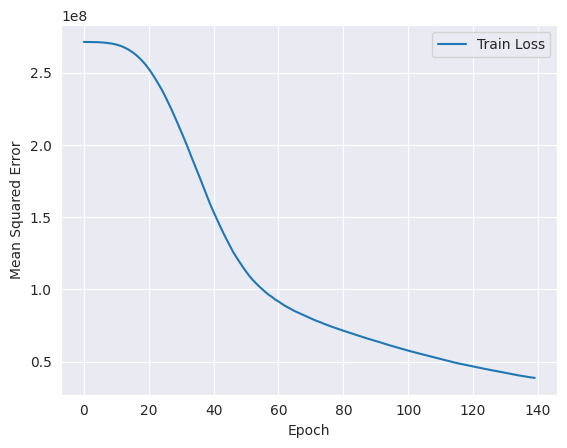

In [15]:
X_train_preprocessed = preprocessor.fit_transform(X_train, y_train)
X_test_preprocessed = preprocessor.transform(X_test)

y_train_preprocessed = np.array(y_train, dtype=np.float32)
y_test_preprocessed = np.array(y_test, dtype=np.float32)

nn = model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_preprocessed.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer with 1 neuron for regression
])
nn.compile(optimizer='adam', loss='mean_squared_error')
history = nn.fit(X_train_preprocessed, y_train_preprocessed, epochs=140, batch_size=32, verbose=1)
prediction = nn.predict(X_test_preprocessed)

plt.plot(history.history['loss'], label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [16]:
r2score = r2_score(y_test_preprocessed, prediction)
mae = mean_absolute_error(y_test_preprocessed, prediction)
mse = mean_squared_error(y_test_preprocessed, prediction)
rmse = np.sqrt(mean_squared_error(y_test_preprocessed, prediction))
print('R2 score : {}'.format(r2score))
print('MAE : {}'.format(mae))
print('MSE : {}'.format(mse))
print('RMSE : {}'.format(rmse))

model_df = pd.DataFrame({'Model Name': [model], 'R2 score': [r2score], 'MAE': [mae], 'MSE': [mse], 'RMSE': [rmse]})
results = pd.concat([results, model_df], ignore_index=True)
display(results.sort_values(by='RMSE', ascending=True))

R2 score : 0.6792957839580736
MAE : 3318.960693359375
MSE : 24671196.0
RMSE : 4967.0107421875


,Model Name,R2 score,MAE,MSE,RMSE
6,([DecisionTreeRegressor(criterion='friedman_ms...,0.933152,1609.006883,5.142501e+06,2267.708326
1,Ridge(),0.924472,1679.765438,5.810221e+06,2410.440094
2,Lasso(),0.920016,1737.076238,6.153026e+06,2480.529320
0,LinearRegression(),0.909236,1893.618872,6.982337e+06,2642.411292
10,LGBMRegressor(),0.896426,1975.361326,7.967754e+06,2822.720974
4,"(DecisionTreeRegressor(max_features=1.0, rando...",0.890713,1819.160442,8.407230e+06,2899.522378
5,"(ExtraTreeRegressor(random_state=811446641), E...",0.860582,1784.018090,1.072514e+07,3274.925632
7,"XGBRegressor(base_score=None, booster=None, ca...",0.855963,1850.409840,1.108052e+07,3328.742022
3,DecisionTreeRegressor(),0.809640,2378.641384,1.464403e+07,3826.752232
8,KNeighborsRegressor(),0.756616,2502.917526,1.872309e+07,4327.018936


# Final model

In [17]:
pipeline = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", gb)]
)
pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Water Resistance',
                                                   'Case Diameter (mm)',
                                                   'Case Thickness (mm)',
                                                   'Band Width (mm)',
                                                   'Power Reserve']),
                                                 ('cat',
                                                  Pipeline(steps=[('lowercase',
                                                                   LowercaseTransformer()),
                                                                  ('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Brand', 'Model',
                                                   'Case Material',
                                                   'Strap Material',
                                                   'Movement Type',
                                                   'Dial Color',
                                                   'Crystal Material',
                                                   'Complications'])])),
                ('model', GradientBoostingRegressor())])

In [18]:
joblib.dump(pipeline, "model.joblib")

['model.joblib']

In [19]:
df.to_csv("processed_df.csv")